In [1]:
# http://www.cvlibs.net/publications/Geiger2013IJRR.pdf
# http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d
# https://github.com/joseph-zhong/KITTI-devkit
# https://github.com/LGNRoy/KITTI_3D_Visulation/blob/main/visualization.ipynb
# https://github.com/traveller59/second.pytorch
# https://gist.github.com/davidstutz/88a12b73813d0e054ece8ab1b53e58a9
# https://github.com/sjdh/kitti-3d-detection/blob/master/kitti/data.py
# https://github.com/whatdhack/computer_vision/blob/master/kitti_3dobj_det_chk/kitti_3dobj_det_chk.py
# https://github.com/navoshta/KITTI-Dataset/blob/master/kitti-dataset.ipynb

# Dataset

```
.
├── data_object_calib.zip
├── data_object_image_2.zip
├── data_object_label_2.zip
├── data_object_velodyne.zip
├── testing
│   ├── calib
│   │   ├── 000000.txt
│   │   ├── 000001.txt
│   │   ├── 007516.txt
│   │   └── 007517.txt
│   └── image_2
│       ├── 000000.png
│       ├── 000001.png
│       └── 007517.png
└── training
    ├── calib
    │   ├── 000000.txt
    │   ├── 000001.txt
    │   └── 007480.txt
    ├── image_2
    │   ├── 000000.png
    │   ├── 000001.png
    │   └── 007480.png
    ├── label_2
    │   ├── 000000.txt
    │   ├── 000001.txt
    │   └── 007480.txt
    └── velodyne
        ├── 000000.bin
        ├── 000001.bin
        └── 007480.bin

8 directories, 44709 files
```

In [1]:
# Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01

# 712.40 143.00 810.73 307.92
# 1.89 0.48 1.20
# 1.84 1.47 8.41

In [87]:
import torch.utils.data as data

import os
import glob
from PIL import Image
from PIL import ImageDraw
import numpy as np
import copy
import math
import matplotlib.pyplot as plt

class MonoKitti3D(data.Dataset):
    def __init__(self, root_dir='/paddle/workspace/kitti/', ):
        '''KittiDetection3D
        '''
        categories = ('Pedestrian', 'Cyclist', 'Car')
        occluded = (0, 1, 2, 3)
        
        train_root = os.path.join(root_dir, 'training') 
        anno_dirs = ['image_2', 'label_2', 'calib', 'velodyne']
        ext_names = ['png', 'txt', 'txt', 'bin']
        paths = {}
        for k, ext in zip(anno_dirs, ext_names):
            paths[k] = sorted(glob.glob(os.path.join(train_root, k, '*.{}'.format(ext))))
            # paths[k] = lambda idx: os.path.join(train_root, k, '{:0>6}.png'.format(idx))
        
        self.paths = paths
        self.length = len(paths['image_2'])
        self.occluded = occluded
        self.categories = categories

        
    def __len__(self, ):
        return self.length
    
    
    def __getitem__(self, idx):
        
        blobs = {}
        blobs.update(self._load_image(idx))
        blobs.update(self._load_annos(idx))
        blobs.update(self._load_calib(idx))
        
        blobs = self._build_target(blobs)
        
        return blobs
    
    
    def _build_target(self, blobs):
        '''
        '''
        corners, centers = [], []
        for loc, dim, ry in zip(blobs['locations'], blobs['dimensions'], blobs['rotation_y']):
            corners.append(self._3d_corners(loc, dim, self._rotate_matrix(ry)))
            centers.append(loc + [0, -dim[0]/2, 0])

        blobs['corners'] = np.array(corners)
        blobs['center3d'] = np.array(centers).T
        
        return blobs
    
    
    def _coord_(self, ):
        '''
        camera: x=right, y=down, z=forward
        '''
        pass
    
    
    def _location_(self, loc, dims):
        '''
        '''
        pass
    
    
    @staticmethod
    def _rotate_matrix(ry):
        '''yam _rotate_matrix
        '''
        R = np.array([[math.cos(ry), 0, math.sin(ry)], 
                      [0, 1, 0], 
                      [-math.sin(ry), 0, math.cos(ry)]])
        return R
    
    
    @staticmethod
    def _3d_corners(loc, dims, R):
        '''
        y z x(h w l)(kitti label file) <-> x y z(l h w)(camera)
        args:
            loc, [x, y, z]
            dims, [h, w, l]
            R, rotate matrix
        return
            corners [3, 8]
        '''
        l, h, w = dims
        x_corners = np.array([l, l, 0, 0, l, l, 0, 0]) - l/2
        y_corners = np.array([h, h, h, h, 0, 0, 0, 0]) - h
        z_corners = np.array([w, 0, 0, w, w, 0, 0, w]) - w/2
        corners = np.vstack([x_corners, y_corners, z_corners])
        corners = R @ corners + np.array(loc).reshape(3, 1)

        return corners
    
    
    def _cam0_cam2(self, loc, dim, blobs):
        '''        
        loc = blobs['locations'][0][np.newaxis, :]
        dim = blobs['dimensions'][0][np.newaxis, :]
        self._cam0_cam2(loc, dim, blobs)
        '''
        _loc = self._to_homo_coord(loc.copy())
        
        dst = np.array([0.5, 0.5, 0.5])
        src = np.array([0.5, 1.0, 0.5])
        loc = loc + dim * (dst - src)
        
        offset = (blobs['P2'][0, 3] - blobs['P0'][0, 3]) / blobs['P2'][0, 0]
        
        loc_3d = np.copy(loc)
        loc_3d[0, 0] += offset
                
        # _loc = blobs['P2'] @ blobs['R0_rect'] @ _loc.T
        _loc = blobs['P2'] @ _loc.T
        
        return loc_3d
    
        
    def _to_homo_coord(self, matrix):
        '''nx3 -> nx4
        '''
        _ext = np.zeros((matrix.shape[0], 1))
        _ext[:, -1] = 1
        
        return np.concatenate((matrix, _ext), axis=-1)
    
    
    def _load_image(self, idx):
        path = self.paths['image_2'][idx]
        img = Image.open(path).convert('RGB')
        
        return {'image': img}
    
    
    def _load_annos(self, idx):
        path = self.paths['label_2'][idx]

        blobs = {}
        with open(path, 'r') as f:
            lines = [lin.strip() for lin in f.readlines()]
            
            lines = [lin.split(' ') for lin in lines if len(lin) > 0]
            
            if self.categories is not None:
                lines = [lin for lin in lines if lin[0] in self.categories]

            if self.occluded is not None:
                lines = [lin for lin in lines if int(lin[2]) in self.occluded]
            
            types = np.array([self.categories.index(lin[0]) for lin in lines])
            annos = np.array([list(map(float, lin[1:])) for lin in lines])
            annos = np.concatenate((types.reshape(-1, 1), annos), axis=-1)
            
            blobs['index'] = idx
            blobs['classes'] = [lin[0] for lin in lines]
            blobs['types'] = annos[:, 0]
            blobs['truncated'] = annos[:, 1]
            blobs['occluded'] = annos[:, 2]
            blobs['alpha'] = annos[:, 3]
            blobs['bboxes'] = annos[:, 4:8]
            blobs['dimensions'] = annos[:, 8:11][:, [2, 0, 1]] # hwl format to standard lhw(camera) format.
            blobs['locations'] = annos[:, 11:14]
            blobs['rotation_y'] = annos[:, 14]

        return blobs
        
        
    def _load_calib(self, idx):
        path = self.paths['calib'][idx]
        
        blobs = {}
        with open(path, 'r') as f:
            lines = [lin.strip() for lin in f.readlines()]
            lines = [lin for lin in lines if len(lin) > 0]
            
            for lin in lines:
                items = [item.strip() for item in lin.strip().split(':')]
                values = [float(x) for x in items[1].strip().split(' ')]
                matrix = np.eye(4)
                if items[0] == 'R0_rect':
                    matrix[:3, :3] = np.array(values).reshape(3, 3)
                else:
                    matrix[:3, :4] = np.array(values).reshape(3, 4)
                
                blobs[items[0]] = matrix
                
        return blobs
            
        
    def _load_velodyne(self, idx):
        
        return {}
    
    
    def show(self, idx):
        '''show
        '''
        blobs = self[idx]
        image = copy.deepcopy(blobs['image'])
        draw = ImageDraw.Draw(image)
        
        print(blobs['rotation_y'])
        
        for bbx in blobs['bboxes']:
            draw.rectangle(tuple(bbx), outline='red')
            x = (bbx[0::2]).sum() / 2
            y = (bbx[1::2]).sum() / 2
            draw.ellipse((x-3, y-3, x+3, y+3), fill='red')
        
        for pts in blobs['corners']:
            pts = blobs['P2'] @ self._to_homo_coord(pts.T).T
            
            for pt in pts.T:
                x = pt[0] / pt[2]
                y = pt[1] / pt[2]
                draw.ellipse((x-3, y-3, x+3, y+3), fill='blue')
        
        for pts in blobs['corners']:
            pts = point3d_to_image(pts.T, blobs['P2'])
            # print(pts)
            for pt in pts:
                x, y = pt[0], pt[1]
                draw.ellipse((x-3, y-3, x+3, y+3), fill='blue')

                
        pts = blobs['P2'][:3, :3] @ blobs['center3d']
        for pt in pts.T:
            x = pt[0] / pt[2]
            y = pt[1] / pt[2]
            draw.ellipse((x-3, y-3, x+3, y+3), fill='green')

            
        for pts in blobs['corners']:
            pts = point3d_to_image(pts.T, blobs['P2'])
            draw_box_3d(draw, pts)
            
            
        return image
    

    
    def Draw3D(self, idx):
        
        blobs = self[idx]
        
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d') 
        colors = {'Car': 'b', 'Tram': 'r', 'Cyclist': 'g', 'Van': 'c', 
                  'Truck': 'm', 'Pedestrian': 'y', 'Sitter': 'k'}

        draw_point_cloud(ax, blobs['corners'], [colors[c] for c in blobs['classes']])
        
        plt.show()


def point3d_to_image(points, K):
    '''
    args:
        m x 3
        4 x 4
    return:
        m x 2
    '''
    if points.shape[-1] == 3:
        points = np.concatenate((points, np.ones(list(points.shape[:-1]) + [1, ])), axis=-1)
        
    _points = K @ points.T
    _points = _points.T
    _points[:, 0] =  _points[:, 0] / _points[:, 2]
    _points[:, 1] =  _points[:, 1] / _points[:, 2]

    # _points[:, [0, 1]] /= _points[:, [2]]

    return _points[:, [0, 1]]


def draw_point_cloud(ax, corners, colors, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
    '''draw_point_cloud
    '''
    axes_str = ['X', 'Y', 'Z']
    axes_limits = [[-20, 20], [-20, 20], [0, 30]]

    ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
    ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
    if len(axes) > 2:
        ax.set_xlim3d(*axes_limits[axes[0]])
        ax.set_ylim3d(*axes_limits[axes[1]])
        ax.set_zlim3d(*axes_limits[axes[2]])
        ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
    else:
        ax.set_xlim(*axes_limits[axes[0]])
        ax.set_ylim(*axes_limits[axes[1]])

    if xlim3d!=None:
        ax.set_xlim3d(xlim3d)
    if ylim3d!=None:
        ax.set_ylim3d(ylim3d)
    if zlim3d!=None:
        ax.set_zlim3d(zlim3d)

    for i, c in enumerate(colors):
        draw_box(ax, corners[i], axes=axes, color=c)
        
        
def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.

    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)


[-1.42  1.76  1.75 -1.44 -1.39  1.78  1.79 -1.4   2.02]


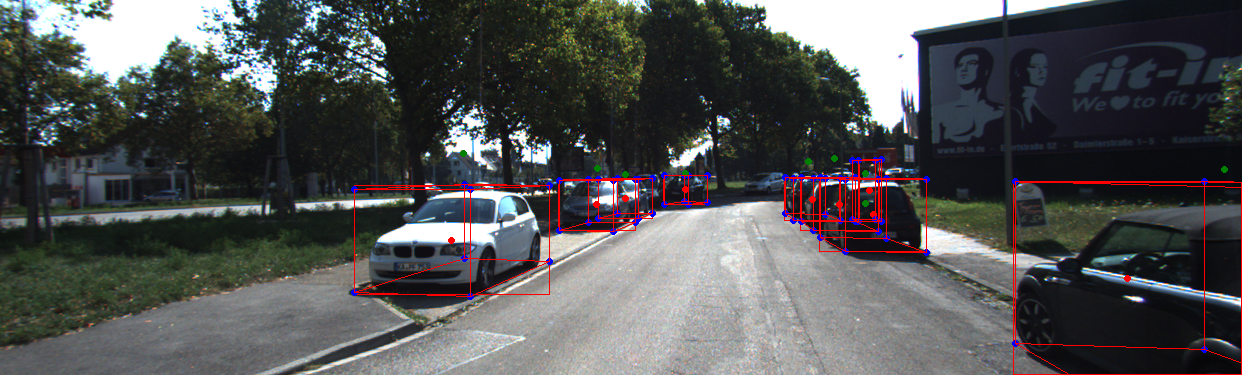

In [88]:
dataset = MonoKitti3D()
n = 10
dataset.show(n)


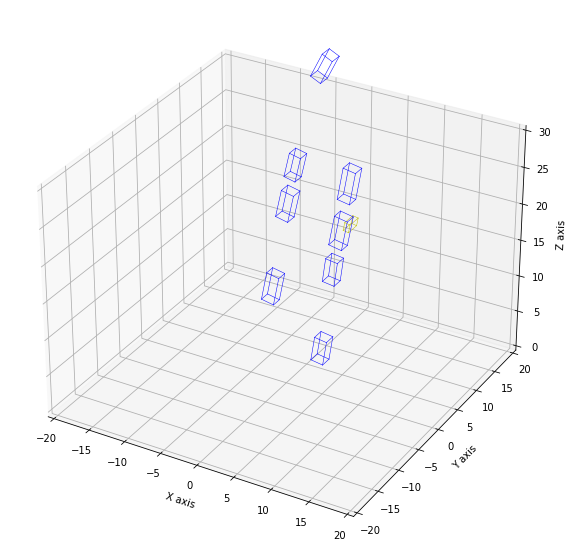

In [82]:
dataset.Draw3D(n)

```
###########################################################################
#            THE KITTI VISION BENCHMARK SUITE: OBJECT BENCHMARK           #
#              Andreas Geiger    Philip Lenz    Raquel Urtasun            #
#                    Karlsruhe Institute of Technology                    #
#                Toyota Technological Institute at Chicago                #
#                             www.cvlibs.net                              #
###########################################################################

For recent updates see http://www.cvlibs.net/datasets/kitti/eval_object.php.

This file describes the KITTI 2D object detection and orientation estimation
benchmark, the 3D object detection benchmark and the bird's eye view benchmark.
The benchmarks consist of 7481 training images (and point clouds) 
and 7518 test images (and point clouds) for each task.
Despite the fact that we have labeled 8 different classes, only the
classes 'Car' and 'Pedestrian' are evaluated in our benchmark, as only for
those classes enough instances for a comprehensive evaluation have been
labeled. The labeling process has been performed in two steps: First we
hired a set of annotators, to label 3D bounding boxe tracklets in point
clouds. Since for a pedestrian tracklet, a single 3D bounding box tracklet
(dimensions have been fixed) often fits badly, we additionally labeled the
left/right boundaries of each object by making use of Mechanical Turk. We
also collected labels of the object's occlusion state, and computed the
object's truncation via backprojecting a car/pedestrian model into the
image plane.

NOTE: WHEN SUBMITTING RESULTS, PLEASE STORE THEM IN THE SAME DATA FORMAT IN
WHICH THE GROUND TRUTH DATA IS PROVIDED (SEE BELOW), USING THE FILE NAMES
000000.txt 000001.txt ... CREATE A ZIP ARCHIVE OF THEM AND STORE YOUR
RESULTS (ONLY THE RESULTS OF THE TEST SET) IN ITS ROOT FOLDER.

NOTE2: Please read the bottom of this file carefully if you plan to evaluate
results yourself on the training set.

NOTE3: WHEN SUBMITTING RESULTS FOR THE 3D OBJECT DETECTION BENCHMARK OR THE
BIRD'S EYE VIEW BENCHMARK (AS OF 2017), READ THE INSTRUCTIONS BELOW CAREFULLY.
IN PARTICULAR, MAKE SURE TO ALWAYS SUBMIT BOTH THE 2D BOUNDING BOXES AND THE
3D BOUNDING BOXES AND FILTER BOUNDING BOXES NOT VISIBLE ON THE IMAGE PLANE.

Data Format Description
=======================

The data for training and testing can be found in the corresponding folders.
The sub-folders are structured as follows:

  - image_02/ contains the left color camera images (png)
  - label_02/ contains the left color camera label files (plain text files)
  - calib/ contains the calibration for all four cameras (plain text file)

The label files contain the following information, which can be read and
written using the matlab tools (readLabels.m, writeLabels.m) provided within
this devkit. All values (numerical or strings) are separated via spaces,
each row corresponds to one object. The 15 columns represent:

#Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.

Here, 'DontCare' labels denote regions in which objects have not been labeled,
for example because they have been too far away from the laser scanner. To
prevent such objects from being counted as false positives our evaluation
script will ignore objects detected in don't care regions of the test set.
You can use the don't care labels in the training set to avoid that your object
detector is harvesting hard negatives from those areas, in case you consider
non-object regions from the training images as negative examples.

The coordinates in the camera coordinate system can be projected in the image
by using the 3x4 projection matrix in the calib folder, where for the left
color camera for which the images are provided, P2 must be used. The
difference between rotation_y and alpha is, that rotation_y is directly
given in camera coordinates, while alpha also considers the vector from the
camera center to the object center, to compute the relative orientation of
the object with respect to the camera. For example, a car which is facing
along the X-axis of the camera coordinate system corresponds to rotation_y=0,
no matter where it is located in the X/Z plane (bird's eye view), while
alpha is zero only, when this object is located along the Z-axis of the
camera. When moving the car away from the Z-axis, the observation angle
will change.

To project a point from Velodyne coordinates into the left color image,
you can use this formula: x = P2 * R0_rect * Tr_velo_to_cam * y
For the right color image: x = P3 * R0_rect * Tr_velo_to_cam * y

Note: All matrices are stored row-major, i.e., the first values correspond
to the first row. R0_rect contains a 3x3 matrix which you need to extend to
a 4x4 matrix by adding a 1 as the bottom-right element and 0's elsewhere.
Tr_xxx is a 3x4 matrix (R|t), which you need to extend to a 4x4 matrix 
in the same way!

Note, that while all this information is available for the training data,
only the data which is actually needed for the particular benchmark must
be provided to the evaluation server. However, all 15 values must be provided
at all times, with the unused ones set to their default values (=invalid) as
specified in writeLabels.m. Additionally a 16'th value must be provided
with a floating value of the score for a particular detection, where higher
indicates higher confidence in the detection. The range of your scores will
be automatically determined by our evaluation server, you don't have to
normalize it, but it should be roughly linear. If you use writeLabels.m for
writing your results, this function will take care of storing all required
data correctly.

2D Object Detection Benchmark
=============================

The goal in the 2D object detection task is to train object detectors for the
classes 'Car', 'Pedestrian', and 'Cyclist'. The object detectors must
provide as output the 2D 0-based bounding box in the image using the format
specified above, as well as a detection score, indicating the confidence
in the detection. All other values must be set to their default values
(=invalid), see above. One text file per image must be provided in a zip
archive, where each file can contain many detections, depending on the 
number of objects per image. In our evaluation we only evaluate detections/
objects larger than 25 pixel (height) in the image and do not count 'Van' as
false positives for 'Car' or 'Sitting Person' as false positive for 'Pedestrian'
due to their similarity in appearance. As evaluation criterion we follow
PASCAL and require the intersection-over-union of bounding boxes to be
larger than 50% for an object to be detected correctly.

Object Orientation Estimation Benchmark
=======================================

This benchmark is similar as the previous one, except that you have to
provide additionally the most likely relative object observation angle
(=alpha) for each detection. As described in our paper, our score here
considers both, the detection performance as well as the orientation
estimation performance of the algorithm jointly.

3D Object Detection Benchmark
=============================

The goal in the 3D object detection task is to train object detectors for
the classes 'Car', 'Pedestrian', and 'Cyclist'. The object detectors
must provide BOTH the 2D 0-based bounding box in the image as well as the 3D
bounding box (in the format specified above, i.e. 3D dimensions and 3D locations)
and the detection score/confidence. Note that the 2D bounding box should correspond
to the projection of the 3D bounding box - this is required to filter objects
larger than 25 pixel (height). We also note that not all objects in the point clouds
have been labeled. To avoid false positives, detections not visible on the image plane
should be filtered (the evaluation does not take care of this, see 
'cpp/evaluate_object.cpp'). Similar to the 2D object detection benchmark,
we do not count 'Van' as false positives for 'Car' or 'Sitting Person'
as false positive for 'Pedestrian'. Evaluation criterion follows the 2D
object detection benchmark (using 3D bounding box overlap).

Bird's Eye View Benchmark
=========================

The goal in the bird's eye view detection task is to train object detectors
for the classes 'Car', 'Pedestrian', and 'Cyclist' where the detectors must provide
BOTH the 2D 0-based bounding box in the image as well as the 3D bounding box
in bird's eye view and the detection score/confidence. This means that the 3D
bounding box does not have to include information on the height axis, i.e.
the height of the bounding box and the bounding box location along the height axis.
For example, when evaluating the bird's eye view benchmark only (without the
3D object detection benchmark), the height of the bounding box can be set to
a value equal to or smaller than zero. Similarly, the y-axis location of the
bounding box can be set to -1000 (note that an arbitrary negative value will
not work). As above, we note that the 2D bounding boxes are required to filter
objects larger than 25 pixel (height) and that - to avoid false positives - detections
not visible on the image plane should be filtered. As in all benchmarks, we do
not count 'Van' as false positives for 'Car' or 'Sitting Person' as false positive
for 'Pedestrian'. Evaluation criterion follows the above benchmarks using
a bird's eye view bounding box overlap.

Mapping to Raw Data
===================

Note that this section is additional to the benchmark, and not required for
solving the object detection task.

In order to allow the usage of the laser point clouds, gps data, the right
camera image and the grayscale images for the TRAINING data as well, we
provide the mapping of the training set to the raw data of the KITTI dataset.

This information is saved in mapping/train_mapping.txt and train_rand.txt:

train_rand.txt: Random permutation, assigning a unique index to each image
from the object detection training set. The index is 1-based.

train_mapping.txt: Maps each unique index (= 1-based line numbers) to a zip
file of the KITTI raw data set files. Note that those files are split into
several categories on the website!

Example: Image 0 from the training set has index 7282 and maps to date
2011_09_28, drive 106 and frame 48. Drives and frames are 0-based.

Evaluation Protocol:
====================

For transparency we have included the KITTI evaluation code in the
subfolder 'cpp' of this development kit. It can be compiled via:

g++ -O3 -DNDEBUG -o evaluate_object evaluate_object.cpp

or using CMake and the provided 'CMakeLists.txt'.

IMPORTANT NOTE:

This code will result in 41 values (41 recall discretization steps). Following the MonoDIS paper

https://research.mapillary.com/img/publications/MonoDIS.pdf

from 8.10.2019 we compute the average precision not like in the PASCAL VOC protocol, but as follows:

sum = 0;
for (i=1; i<=40; i++)
  sum += vals[i];
average = sum/40.0;

```

In [86]:
def draw_box_3d(draw, corners, color=None):
    ''' Draw 3d bounding box in image
        corners: (8,2) array of vertices for the 3d box in following order:
    '''

    face_idx = [[0, 1, 5, 4],
                [1, 2, 6, 5],
                [2, 3, 7, 6],
                [3, 0, 4, 7]]
    
    # draw = ImageDraw.draw(image)
            
#     face_idx = [[5, 4, 3, 6],
#                 [1, 2, 3, 4],
#                 [1, 0, 7, 2],
#                 [0, 5, 6, 7]]
    
    for ind_f in range(3, -1, -1):
        f = face_idx[ind_f]
        for j in range(4):
            draw.line(((corners[f[j], 0], corners[f[j], 1]), 
                       (corners[f[(j + 1) % 4], 0], corners[f[(j + 1) % 4], 1])), fill='red', width=0)
            
#         if ind_f == 0:
#             draw.line( ((corners[f[0], 0], corners[f[0], 1]), (corners[f[2], 0], corners[f[2], 1])) , fill='red', width=1)
#             draw.line( ((corners[f[1], 0], corners[f[1], 1]), (corners[f[3], 0], corners[f[3], 1])) , fill='red', width=1)

    
#     return image